# Predicting Brand Sentiment on Twitter

- Nick Gigliotti
- [ndgigliotti@gmail.com](ndgigliotti@gmail.com)

<div><img src="images/apple_logo_black.svg", width=100></div>

# Business Problem

Apple has asked me to create a strong predictive model for detecting positive, negative, and neutral sentiment in tweets. They are primarily concerned with tweets about their company and products, but also might want to know what people are saying about competitors. They intend to use the model to classify new, never-before-seen, tweets, in order to conduct their research. My goals are:

1. Create an accurate classifier which can classify **novel tweets** as positive, negative, or neutral.
2. Find out what people are saying about Apple (at South by Southwest, 2011).
3. Make some recommendations based on my findings.

# Imports
Because there are so many of them, I've created a separate section.
## Standard Library and External

In [1]:
import re
import string
import json
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
from sacremoses import MosesTokenizer
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
)

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## My `tools` Package

I put a lot of time and energy into developing my own tools for analysis. It's probably my favorite part of this kind of work, and I (admittedly) tend to get carried away with it. I developed a lot in `tools.language`, `tools.modeling.vectorizers`, and `tools.modeling.selection` for this project in particular.

#### Caching

Some computationally expensive functions in `tools.language` implement caching, allowing them to save the results of previous calls and reuse them. This **dramatically increases their performance** when being called over and over again as part of a preprocessing pipeline. Essentially, after the function has been called once with certain parameters, every subsequent call with those parameters is fulfilled instantly. This is a highly non-trivial development, which increases the speed of parameter searches (e.g. with `GridSearchCV`) and makes model development more efficient in general.

#### Polymorphism

I've designed the raw-text processing functions in `tools.language` to be polymorphic: capable of handling both a single string document and various types of iterables of documents. This level of flexibility is arguably overkill for the present task.

#### FreqVectorizer

I extended Scikit-Learn's `TfidfVectorizer` to be capable of much more advanced preprocessing out of the box. In addition to the many new text filters, there's built-in stemming and lemmatization, better stopwords selection, and the option to mark negation or parts of speech. See [My `FreqVectorizer`](#my-freqvectorizer) and what comes after for more details.


#### VaderVectorizer

Another notable development is the `VaderVectorizer`, which extracts VADER (Valence Aware Dictionary and Sentiment Reasoner) polarity scores from documents and turns them into short vectors of shape (n_samples, 4). This is essentially just a fancy wrapper around the VADER tools from NLTK, which integrates them with the Scikit-Learn API and implements caching. It proved very useful for the current project. See [Add `VaderVectorizer`](#add-vadervectorizer) and what follows.

#### See also:

[My `sweep` Function](#my-sweep-function) for my generic parameter-space searching function.

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, utils
from tools.modeling.vectorizers import FreqVectorizer, VaderVectorizer
from tools.modeling.classification import diagnostics as diag
from tools.modeling import selection

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# RandomState for reproducibility
rando = np.random.RandomState(9547)

<IPython.core.display.Javascript object>

# Overview of Dataset
Since Apple is interested in sentiment analysis on Twitter, I've found a Twitter dataset with crowdsourced sentiment labels. It comes from [CrowdFlower](https://data.world/crowdflower), which has released other similar datasets.

The tweets are related to South by Southwest, an annual conference and arts festival in Austin, Texas. They are from 2011, when Apple launched the iPad 2.

It has only three features: the tweet text, the brand object of the sentiment, and the sentiment. It has only about 9,100 tweets.

In [3]:
df = pd.read_csv(normpath("data/crowdflower_tweets.csv"))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

The dataset contains one text feature and two categorical features, one of which has a lot of null values. The feature names are very long and wordy, presumably to reflect the actual language used by CrowdFlower in crowdsourcing the dataset. I'm going to rename those before I do anything else.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<IPython.core.display.Javascript object>

# Cleaning
## Renaming

In [5]:
# Assign new column names
df.columns = ["text", "object_of_emotion", "emotion"]
df.head()

,text,object_of_emotion,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<IPython.core.display.Javascript object>

Next, I take a look at the values of the categorical variables. The categories make sense, although the names are longer than necessary. I'm going to shorten some of them as well.

In [6]:
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative emotion
iPad or iPhone App,Positive emotion
iPad,No emotion toward brand or product
Google,I can't tell
Android,
Apple,
Android App,
Other Google product or service,
Other Apple product or service,


<IPython.core.display.Javascript object>

First, I convert the categorical columns to `CategoricalDtype`. This will make it easier to rename the categories, and is a convenient way to differentiate the categorical features from the text column.

In [7]:
# Convert categorical columns to categorical dtype
cat_cols = ["emotion", "object_of_emotion"]
df[cat_cols] = df.loc[:, cat_cols].astype("category")

# Delete temp variable
del cat_cols

# Display results
display(df["emotion"].head(3), df["object_of_emotion"].head(3))

0    Negative emotion
1    Positive emotion
2    Positive emotion
Name: emotion, dtype: category
Categories (4, object): ['I can't tell', 'Negative emotion', 'No emotion toward brand or product', 'Positive emotion']

0                iPhone
1    iPad or iPhone App
2                  iPad
Name: object_of_emotion, dtype: category
Categories (9, object): ['Android', 'Android App', 'Apple', 'Google', ..., 'Other Google product or service', 'iPad', 'iPad or iPhone App', 'iPhone']

<IPython.core.display.Javascript object>

Next, I rename the categories for both categorical features.

I use a single `dict` mapping old category names to new ones. I only need one `dict` for both features because the method `Series.cat.rename_categories(...)` ignores irrelevant keys.

In [8]:
# Create mapping of old categories to new ones
new_cats = {
    # New 'emotion' categories
    "Negative emotion": "Negative",
    "Positive emotion": "Positive",
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Uncertain",
    # New 'object_of_emotion' categories
    "iPad or iPhone App": "iOS App",
    "Other Google product or service": "Other Google Product",
    "Other Apple product or service": "Other Apple Product",
}

# Rename categories in-place (ignores irrelevant keys)
df["emotion"].cat.rename_categories(new_cats, inplace=True)
df["object_of_emotion"].cat.rename_categories(new_cats, inplace=True)

# Delete renaming dict
del new_cats

# Show results
cleaning.show_uniques(df)

object_of_emotion,emotion
iPhone,Negative
iOS App,Positive
iPad,Neutral
Google,Uncertain
Android,
Apple,
Android App,
Other Google Product,
Other Apple Product,


<IPython.core.display.Javascript object>

The 'Neutral' category dominates the distribution, and 'Negative' is very underrepresented. 'Uncertain' is fortunately a very small 2% of the samples. That's good, because it's completely useless to me.

(0.0, 0.75)

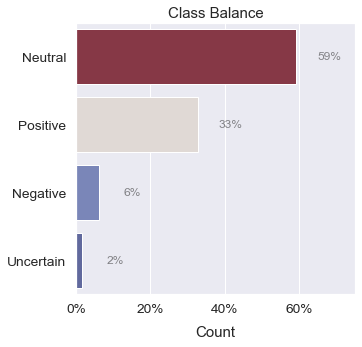

<IPython.core.display.Javascript object>

In [9]:
ax = plotting.countplot(df["emotion"], normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))

I drop the uncertain category, which doesn't have any clear value. I will have to cope with this imbalance later.

'images\\class_balance.svg'

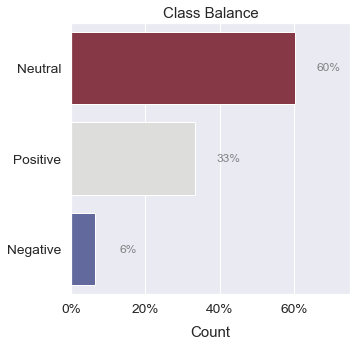

<IPython.core.display.Javascript object>

In [10]:
# Remove 'Uncertain' category
df.emotion.cat.remove_categories("Uncertain", inplace=True)

# Plot class balance
ax = plotting.countplot(df.emotion, normalize=True)
ax.set(title="Class Balance")
ax.set_xlim((0, 0.75))
plotting.save(ax.figure, "images/class_balance.svg")

## Missing Values

According to the table below, there are a lot of missing values in the 'object_of_emotion' category. I bet, however, that these NaN values correspond to the 'Neutral' category. If a tweet doesn't express a brand-emotion, then there shouldn't be any brand in the 'object_of_emotion' column.

There's also one null 'text' row, and a bunch of null 'emotion' rows where the 'Uncertain' category used to be.

In [11]:
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5802,63.81,9,0.10,22,0.24
emotion,156,1.72,3,0.03,22,0.24
text,1,0.01,9065,99.69,22,0.24


<IPython.core.display.Javascript object>

 I'll go ahead and drop the nulls in the 'text' and 'emotion' columns first.

In [12]:
df.dropna(subset=["text", "emotion"], inplace=True)
cleaning.info(df)

,null,null_%,uniq,uniq_%,dup,dup_%
object_of_emotion,5654,63.27,9,0.10,22,0.25
text,0,0.00,8909,99.70,22,0.25
emotion,0,0.00,3,0.03,22,0.25


<IPython.core.display.Javascript object>

In [13]:
null_rows = cleaning.null_rows(df)
lang.readable_sample(null_rows["text"], random_state=rando)

|      | text                                                                                                                                    |
|-----:|:----------------------------------------------------------------------------------------------------------------------------------------|
| 5140 | RT @mention @mention New iPad Apps For Speech Therapy And Communication Are Showcased At #SXSW Conference {link} #sxswi #hcsm #sxswh    |
|  509 | Please RT Follow the next big #college social network @mention chance to win an #iPad at 7,000 followers #socialmedia #SXSW             |
| 4916 | millions of iPhone cases at #SXSW trade show but can any of them double as shuffleboard wax sprinklers? I think not. #fail (CC @mention |
| 6384 | RT @mention not launching any products at #SXSW but we're doing plenty else.  {link}                                                    |
|  790 | Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw&quot;                                             |
| 8793 | Google giving Social another go? {link} Google Circles, let's see what the guys at #SXSW make of it                                     |
| 8452 | @mention The unofficial #SXSW torrents are a great way to hear what you can expect this year {link}                                     |
| 3645 | U gotta fight for yr right to party &amp; to privacy ACLU/google #sxsw #partylikeits1986                                                |
|   61 | #futuremf @mention {link} spec for recipes on the web, now in google search: {link}  #sxsw                                              |
| 4081 | Hope people ask the tough questions. RT @mention Reminder: Android and Chrome TTS talk @mention 1 PM today!  {link}  #sxsw              |

<IPython.core.display.Javascript object>

Looks like some of the NaN values don't line up with the 'Neutral' category. Also, it's important to note that some retweets, e.g. 64, 68, do have sentimental content beyond that of the original tweet.

In [14]:
emotion_without_object = null_rows.loc[null_rows.emotion != "Neutral"]

# Delete variable
del null_rows

display(emotion_without_object.head(), emotion_without_object.shape)

,text,object_of_emotion,emotion
46,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...,NaN,Positive
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative
68,Boooo! RT @mention Flipboard is developing an ...,NaN,Negative
103,Know that &quot;dataviz&quot; translates to &q...,NaN,Negative
112,Spark for #android is up for a #teamandroid aw...,NaN,Positive


(357, 3)

<IPython.core.display.Javascript object>

These are positive tweets which are missing a brand label. Many of them seem positive, some towards a brand and some not. The original features names were 'emotion_in_tweet_is_directed_at' and 'is_there_an_emotion_directed_at_a_brand_or_product', which is not consistent with brandless positivity. But this is data science, and in data science, nothing is consistent.

In [15]:
lang.readable_sample(
    emotion_without_object.groupby("emotion").get_group("Positive").text,
    random_state=456,
)

|      | text                                                                                                                                           |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------------|
| 6606 | RT @mention RT @mention Shiny new @mention @mention @eightbit apps, a new @garyvee book, pop-up iPad 2 stores... #SXSW is Christmas for nerds. |
| 4164 | Mad long line for Google party at Maggie Mae's. Hope it's worth it.. but with 80s theme I am very optimistic #sxsw                             |
| 3020 | Apple offers original iPad donation program {link} #entry #friends #house #sxsw                                                                |
| 8114 | #touchingstories giving us the background to STARTING. Great to hear after yesterday's presos on #uncertainty #iPad and/or #tablet #SXSW       |
|  555 | I have my golden tickets f 4sq party Day after the real party #Redbullbpm with Felix da Housecat playing on iPad! #SXSW  {link}                |
| 5501 | RT @mention At #sxsw even the cabbies are tech savvy. That's his iPhone streaming twitter. @mention  {link}                                    |
| 6676 | RT @mention Soundtrckr featured by @mention @mention as a Must-have for #SXSW {link}                                                           |
|  157 | @mention  #SXSW LonelyPlanet Austin guide for #iPhone is free for a limited time {link} #lp #travel                                            |
| 5019 | Here he comes ladies! @mention  @mention  RT @mention I'll be at Austin Convention Center w/  @mention showing my  iPhone game. #SXSW          |
| 8025 | Someone asks Leo about an iPad 2 at #SXSW, he says 'Email me, I'll send you one free'. O.o                                                     |

<IPython.core.display.Javascript object>

Fortunately there aren't very many of them, so not much hangs on my decision to go ahead and fill in the missing brands.

In [16]:
# Create regex for finding each brand
re_apple = r"ipad\d?\s*app|ipad\d?|iphone\s*app|iphone|apple"
re_google = r"android\s*app|android|google"

# Find all brand/product name occurrences for each brand
findings = lang.locate_patterns(
    re_apple,
    re_google,
    strings=emotion_without_object["text"],
    exclusive=True,
    flags=re.I,
)

# Convert to lowercase
findings = findings.str.lower()

# View results
display(
    findings.value_counts(),
    findings.size,
)

google         122
ipad            98
apple           76
iphone          57
ipad2           26
android         19
iphone app       8
ipad app         4
android app      1
ipad1            1
Name: locate_patterns, dtype: int64

412

<IPython.core.display.Javascript object>

In [17]:
# Rename Apple apps to match categories defined previously
findings = findings.str.replace(
    r"ipad\s+app|iphone\s+app", "ios app", case=False, regex=True
)

# Fuzzy match with previously defined categories
findings = lang.fuzzy_match(findings, df["object_of_emotion"].cat.categories)

# View results
findings.sort_values("score")

,original,match,score
5401,ipad2,iPad,89
3179,ipad2,iPad,89
8149,ipad2,iPad,89
6309,ipad2,iPad,89
3710,ipad2,iPad,89
...,...,...,...
3224,ipad,iPad,100
3179,ipad,iPad,100
3134,google,Google,100
3055,ipad,iPad,100


<IPython.core.display.Javascript object>

In [18]:
# Define sort order, i.e. fill priority
order = [
    "iOS App",
    "Android App",
    "iPhone",
    "iPad",
    "Android",
    "Apple",
    "Google",
]

# Sort values in reverse order
utils.explicit_sort(
    findings,
    order=order,
    by="match",
    ascending=False,
    inplace=True,
)

# Fill in reverse, overwriting lower priority values
for i, brand in findings.match.items():
    df.at[i, "object_of_emotion"] = brand
df.loc[findings.index].sample(10, random_state=rando)

,text,object_of_emotion,emotion
8029,"Yeah I wasn't doing it, but I got couldn't res...",iPad,Positive
2753,I love the waves!!!!!! {link} iPad Webber #jap...,iPad,Positive
8973,Google guy at #sxsw talk is explaining how he ...,Google,Negative
1089,���@mention So @mention just spilled the beans...,iPhone,Positive
4674,Apple opening up temporary store in downtown A...,iPad,Positive
4536,Whoa - line for ipad2 is 3blks long!!! #apple ...,iPad,Positive
6078,RT @mention I'm debuting my new iPhone &amp; D...,iPhone,Positive
6710,RT @mention Temporary #apple store is def not ...,Apple,Positive
682,#technews iPad 2 Gets Temporary Apple Store fo...,iPad,Positive
5501,RT @mention At #sxsw even the cabbies are tech...,iPhone,Positive


<IPython.core.display.Javascript object>

In [19]:
# Get indices which were not filled
emotion_without_object.drop(findings.index, inplace=True)

# Drop unfilled observations
df.drop(emotion_without_object.index, inplace=True)

print(f"{emotion_without_object.shape[0]} observations dropped.")

del emotion_without_object

24 observations dropped.


<IPython.core.display.Javascript object>

Here are the tweets which are labeled 'Neutral' but have a brand label, implying that a non-neutral emotion is being expressed towards a brand. Most 'Neutral' tweets do not have a brand label, so these 91 tweets are an anomaly.

In [20]:
object_without_emotion = df.loc[
    (df.emotion == "Neutral") & df.object_of_emotion.notnull()
]
display(object_without_emotion.head(), object_without_emotion.shape)

,text,object_of_emotion,emotion
63,#Smile RT @mention I think Apple's &quot;pop-u...,Apple,Neutral
265,The #SXSW Apple &quot;pop-up&quot; store was n...,Apple,Neutral
317,I arrived at #sxsw and my @mention issue hasn'...,iOS App,Neutral
558,haha. the google &quot;Party like it's 1986&qu...,Google,Neutral
588,Diller on Google TV: &quot;The first product w...,Other Google Product,Neutral


(91, 3)

<IPython.core.display.Javascript object>

Tweet 6517 seems clearly negative to me, and 7137 seems kind of sardonic. 2666 seems weakly positive. 8647, 5696, 7521, 668, and 265 don't seem to express an emotion toward a brand or product. Since most of them seem neutral to me, and that's consistent with their 'Neutral' label, I'm going to keep them that way.

In [21]:
lang.readable_sample(object_without_emotion["text"], random_state=rando)

|      | text                                                                                                                                              |
|-----:|:--------------------------------------------------------------------------------------------------------------------------------------------------|
|  668 | #sxsw guy in front of me at this panel has an ipad in an etch-a-sketch case...device of wondeR? #iusxsw                                           |
| 1628 | @mention @mention Similarily, Tweetcaster for Android lets you zip tweets w annoying hash tags, like #sxsw                                        |
| 1253 | Google vp to speak. The topic: 10 quick steps to owning everything in the world. #sxsw {link}                                                     |
| 2849 | Nice to see the speaker sneak in an irrelevant snarky comment about Apple. Class!  #sxsw #authenticationdesign                                    |
| 7658 | Score a free imo tshirt outside the SXSW Apple store today at 2:15 PM &amp; check out imo's app for the iPad 2  {link}  #sxsw #ipad2              |
| 4119 | From #Apple to Naomi Campbell: pop-up stores are all the rage: {link} #sxsw                                                                       |
| 5912 | RT @mention Google to launch new social network at SXSW? - CNET News {link} #sxsw                                                                 |
| 6082 | RT @mention I'm not really at #sxsw. Just messing with you. I'm making money instead. // I bet someone left the iPad queue                        |
| 6491 | RT @mention RT @mention &quot;IAVA wants to be the Google of nonprofits.&quot; / yes, we do b/c our #vets deserve nothing less! #sxsw #letshookup |
| 8902 | @mention Which is to say iPad is going to be ubiquitous a lot faster than anyone expected a year or even 6 mo. ago. #newsapps #sxsw               |

<IPython.core.display.Javascript object>

In [22]:
# Set object to null where emotion is neutral
df.loc[object_without_emotion.index, "object_of_emotion"] = np.nan

# Ensure that 'Neutral' rows line up with 'NaN' rows
(df["emotion"] == "Neutral").equals(df["object_of_emotion"].isnull())

True

<IPython.core.display.Javascript object>

Here's a look at the final distributions.

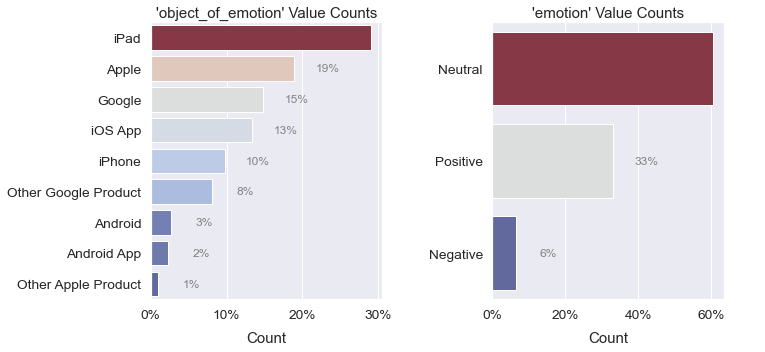

<IPython.core.display.Javascript object>

In [23]:
fig = plotting.countplot(df.select_dtypes("category"), normalize=1)

## Duplicates
There are $22$ duplicate rows, and even more when only the text is considered. I don't want to get rid of all retweets, but I do want to get rid of those which don't have novel content.

In [24]:
cleaning.dup_rows(df.text).sort_values()

3962    #SXSW is just starting, #CTIA is around the co...
468        Before It Even Begins, Apple Wins #SXSW {link}
2559    Counting down the days to #sxsw plus strong Ca...
776     Google to Launch Major New Social Network Call...
8483    I just noticed DST is coming this weekend. How...
2232    Marissa Mayer: Google Will Connect the Digital...
8747    Need to buy an iPad2 while I'm in Austin at #s...
4897    Oh. My. God. The #SXSW app for iPad is pure, u...
5882    RT @mention Google to Launch Major New Social ...
5884    RT @mention Google to Launch Major New Social ...
5883    RT @mention Google to Launch Major New Social ...
5881    RT @mention Google to Launch Major New Social ...
5885    RT @mention Google to Launch Major New Social ...
6299    RT @mention Marissa Mayer: Google Will Connect...
6297    RT @mention Marissa Mayer: Google Will Connect...
6295    RT @mention Marissa Mayer: Google Will Connect...
6300    RT @mention Marissa Mayer: Google Will Connect...
6298    RT @me

<IPython.core.display.Javascript object>

I filter the text by removing occurrences of 'RT' and then check for duplicates. This should get rid of retweets which are just copies of original tweets in the dataset.

In [25]:
dups = df.text.str.replace(r"\s*RT\s*", "", regex=True).duplicated()
df = df.loc[~dups]
dups.sum()

33

<IPython.core.display.Javascript object>

# Feature Engineering

I create a 'clean_text' feature for exploratory purposes using text preprocessing functions. Then I extract brand terms from the tweets for use in the model, and extract some basic statistics for exploratory purposes.

But before I do anything, I want to define some stopwords for this particular project.

In [26]:
# SXSW and Twitter stopwords
my_stop = frozenset(
    {
        "america",
        "austin",
        "link",
        "mention",
        "quot",
        "rt",
        "southbysouthwest",
        "sxsw",
        "sxswi",
    }
)

# Brand-related stopwords
brand_stop = frozenset(
    {
        "app",
        "androidsxsw",
        "apple",
        "applesxsw",
        "android",
        "google",
        "iphone",
        "ipad",
        "andoid",
    }
)

my_stop, brand_stop

(frozenset({'america',
            'austin',
            'link',
            'mention',
            'quot',
            'rt',
            'southbysouthwest',
            'sxsw',
            'sxswi'}),
 frozenset({'andoid',
            'android',
            'androidsxsw',
            'app',
            'apple',
            'applesxsw',
            'google',
            'ipad',
            'iphone'}))

<IPython.core.display.Javascript object>

I save the stopword sets in JSON.

In [27]:
# Create JSON-serializable dict
stopwords = {
    "my_stop": list(my_stop),
    "brand_stop": list(brand_stop),
}

# Save my stopwords
with open("data/stopwords.json", "w") as f:
    json.dump(stopwords, f)

del stopwords

<IPython.core.display.Javascript object>

### Text-Processing Functions
Most of these functions from my `tools.language` module are wrappers around functions from `gensim.parsing.preprocessing` or `nltk`.

Probably the most complex is `wordnet_lemmatize`, which tags parts of speech, translates the tags, and then lemmatizes the tagged tokens.

My `lang.make_preprocessor` function turns a list of functions into a single, polymorphic, callable. The resulting "preprocessor" (`filts`) can be passed a single string or a collection of strings and will apply the chain of functions elementwise.

In [28]:
filts = [
    lang.lowercase,
    lang.strip_twitter_handles,
    lang.uni2ascii,
    lang.strip_numeric,
    # Tokenize with MosesTokenizer
    lang.moses_tokenize,
    lang.filter_length,
    partial(lang.filter_stopwords, stopwords=my_stop),
    lang.wordnet_lemmatize,
    # Detokenize with MosesDetokenizer
    lang.moses_detokenize,
    lang.strip_multiwhite,
]
filts = lang.make_preprocessor(filts)
filts

functools.partial(<function chain_processors at 0x000001557050D4C0>, funcs=[<function lowercase at 0x00000155704FC940>, <function strip_twitter_handles at 0x00000155704FCE50>, <function uni2ascii at 0x00000155704FE3A0>, <function strip_numeric at 0x00000155704FCB80>, <function moses_tokenize at 0x00000155704FE9D0>, <function filter_length at 0x00000155704FC160>, functools.partial(<function filter_stopwords at 0x00000155704FC310>, stopwords=frozenset({'rt', 'southbysouthwest', 'link', 'sxsw', 'sxswi', 'mention', 'austin', 'america', 'quot'})), <function wordnet_lemmatize at 0x00000155704EFCA0>, <function moses_detokenize at 0x00000155704EF1F0>, <function strip_multiwhite at 0x00000155704FC9D0>])

<IPython.core.display.Javascript object>

<a id='what-is-partial'></a>

### What is `partial`?

You'll see me use `functools.partial` pretty often. It creates a thin wrapper over an existing function with some preset arguments held in place. It's like creating a wrapper with new default parameters, except that `functools.partial` can hold positional arguments in place too. It comes in handy in many situations. For example, the `filts` callable I just created is actually a `partial` object which wraps another function, `lang.chain_processors`, and holds a list of functions as the keyword argument `funcs`.

I create a 'clean_text' feature for exploratory purposes and general convenience.

In [29]:
df["clean_text"] = filts(df["text"])
df.clean_text.head()

0    have iphone. after hr tweet rise be dead need ...
1    know about awesome ipad iphone app that you'll...
2    can not wait for ipad also. they should sale t...
3    hope this year's festival isn't crashy this ye...
4    great stuff fri marissa mayer google tim'reill...
Name: clean_text, dtype: object

<IPython.core.display.Javascript object>

## Brand Terms
I extract brand terms based on the crowdsourced labels using regular expressions. I'm comfortable using these for training the model, since they were extracted algorithmically.

In [30]:
# Combine my previous brand patterns
re_brand = fr"{re_apple}|{re_google}"

# Extract from 'clean_text' with document indices
regex_brands = lang.locate_patterns(re_brand, strings=df.clean_text)

# Retract into nested lists and insert in `df`
regex_brands = utils.implode(regex_brands).reindex_like(df)
df["brand_terms"] = regex_brands
del regex_brands

df["brand_terms"].head()

0              [iphone]
1    [ipad, iphone app]
2                [ipad]
3          [iphone app]
4              [google]
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

I then process the terms I've extracted for use in the model. I need to unify terms like 'iphone app' which contain a space, and correct spelling errors like 'iphoneapp'. I also need to explicitly create a 'None' category, since not mentioning any of the relevant brands is an interesting property for a tweet.

In [31]:
df["brand_terms"] = utils.implode(
    # Retract the exploded Series
    df["brand_terms"]
    # Explode the nested lists
    .explode()
    # Replace space with underscore
    .str.replace(" ", "_")
    # Deal with cases like 'iphoneapp'
    .str.replace(r"([a-zA-Z]+)app", lambda x: f"{x[1]}_app", regex=True)
    # Create a 'none' category
    .fillna("none")
)

# View uniques to confirm
df["brand_terms"].explode().unique()

array(['iphone', 'ipad', 'iphone_app', 'google', 'ipad_app', 'android',
       'apple', 'android_app', 'none'], dtype=object)

<IPython.core.display.Javascript object>

## Simple Counts

I engineer character counts (minus spaces), word counts, and average word lengths for exploratory purposes. Maybe an interesting pattern will show up.

In [32]:
# String length without whitespace
df["n_chars"] = df["text"].str.replace("\s+", "", regex=True).map(len)

# Number of words as parsed by TweetTokenizer
df["n_words"] = df["text"].map(nltk.casual_tokenize).map(len)

# Calculate average word length
df["avg_word_len"] = df["n_chars"] / df["n_words"]

# Show results
df[["n_chars", "n_words", "avg_word_len"]].head()

,n_chars,n_words,avg_word_len
0,104,29,3.586207
1,118,26,4.538462
2,65,17,3.823529
3,68,16,4.250000
4,115,27,4.259259


<IPython.core.display.Javascript object>

I engineer exclamation point and question mark counts, which I've discovered have a surprisingly robust connection to sentiment.

In [33]:
df["ep_count"] = df["text"].str.count(r"\!")
df["qm_count"] = df["text"].str.count(r"\?")
df[["ep_count", "qm_count"]].head()

,ep_count,qm_count
0,1,0
1,0,1
2,0,0
3,0,0
4,0,0


<IPython.core.display.Javascript object>

In [34]:
df.to_json(normpath("data/processed_tweets.json"))

<IPython.core.display.Javascript object>

# Modeling

I develop my final model through an iterative process, starting with a basic, baseline version of the model.

Before I do anything, I turn my nested lists of brand terms into strings which can be vectorized.

In [35]:
df["brand_terms"] = df["brand_terms"].str.join(" ")
df["brand_terms"].head()

0             iphone
1    ipad iphone_app
2               ipad
3         iphone_app
4             google
Name: brand_terms, dtype: object

<IPython.core.display.Javascript object>

## Train-Test-Split

I perform the train-test split which I'll use throughout my modeling process. I let `X` and its derivatives be `DataFrame` objects because I plan to use a `ColumnTransformer` to process the two columns separately.

In [36]:
cols = [
    "text",
    "brand_terms",
]

# Define X and y
X = df.loc[:, cols].copy()
y = df.emotion.to_numpy()

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=rando,
    stratify=y,
    shuffle=True,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6659, 2), (6659,), (2220, 2), (2220,))

<IPython.core.display.Javascript object>

## Baseline Model

I first create a `ColumnTransformer` to process the data from columns of `X` and concatenate the results.

<a id='my-freqvectorizer'></a>

### My `FreqVectorizer`

Inside `col_xform` are two of my `FreqVectorizer` objects. `FreqVectorizer` extends Scikit-Learn's `TfidfVectorizer` and adds a number of powerful preprocessing options. It's called `FreqVectorizer` to emphasize that, like its parent class, it offers several different word-frequency-based vectorization algorithms. Among these algorithms are term frequency (count) vectorization and TF\*IDF (term frequency * inverse document frequency) vectorization. By default, `FreqVectorizer` is set to perform count vectorization.

In `col_xform`, the brand terms ('bra') are effectively one-hot-encoded using simple whitespace tokenization and `binary=True`. This is how the feature was designed to be encoded. The raw text ('txt') is treated with simple count vectorization as a baseline option.

I'll discuss more details of my `FreqVectorizer` class as they become relevant.

In [37]:
col_xform = ColumnTransformer(
    [
        ("txt", FreqVectorizer(), "text"),
        (
            "bra",
            FreqVectorizer(tokenizer=lang.space_tokenize, binary=True),
            "brand_terms",
        ),
    ],
)
col_xform

ColumnTransformer(transformers=[('txt', FreqVectorizer(), 'text'),
                                ('bra',
                                 FreqVectorizer(binary=True,
                                                tokenizer=<function space_tokenize at 0x00000155704FE940>),
                                 'brand_terms')])

<IPython.core.display.Javascript object>

I create a `LogisticRegression` classifier. Logistic Regression is my go-to option for classification, and it performs well on this dataset. Since the `y` classes are wildly imbalanced, I set `class_weight='balanced'`. I also hike up `max_iter` because otherwise the model fails to converge.

In [38]:
logit = LogisticRegression(
    class_weight="balanced",
    max_iter=1e4,
    random_state=rando,
)

logit

LogisticRegression(class_weight='balanced', max_iter=10000.0,
                   random_state=RandomState(MT19937) at 0x15570607440)

<IPython.core.display.Javascript object>

I create my main `Pipeline`, consisting simply of `col_xform` and `logit`.

In [39]:
main_pipe = Pipeline(
    [
        ("col", col_xform),
        ("cls", logit),
    ]
)
main_pipe

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt', FreqVectorizer(),
                                                  'text'),
                                                 ('bra',
                                                  FreqVectorizer(binary=True,
                                                                 tokenizer=<function space_tokenize at 0x00000155704FE940>),
                                                  'brand_terms')])),
                ('cls',
                 LogisticRegression(class_weight='balanced', max_iter=10000.0,
                                    random_state=RandomState(MT19937) at 0x15570607440))])

<IPython.core.display.Javascript object>

Looks like `col_xform` is outputting 9,587 features and 8,879 samples (i.e. vectors, observations, tweets) with the current settings. The features are words (found in the text) and preset brand terms.

In [40]:
vecs = col_xform.fit_transform(X)
vecs

<8879x9587 sparse matrix of type '<class 'numpy.float64'>'
	with 154472 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

Here are the results of the default preprocessing and tokenizing. The minimalist default settings actually look pretty good.

In [41]:
analyzer = col_xform.named_transformers_["txt"].build_analyzer()
df.text.map(analyzer)

0       [wesley83, have, 3g, iphone, after, hrs, tweet...
1       [jessedee, know, about, fludapp, awesome, ipad...
2       [swonderlin, can, not, wait, for, ipad, also, ...
3       [sxsw, hope, this, year, festival, isn, as, cr...
4       [sxtxstate, great, stuff, on, fri, sxsw, maris...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, we, interrupt, your,...
9090    [google, zeiger, physician, never, reported, p...
9091    [some, verizon, iphone, customers, complained,...
9092    [rt, mention, google, tests, check, in, offers...
Name: text, Length: 8879, dtype: object

<IPython.core.display.Javascript object>

I use `functools.partial` to wrap `diagnostics.test_fit` and hold `X_train`, `X_test`, `y_train`, and `y_test` in place. My `diag.test_fit` function just fits a model and displays the standard diagnostic report. See [What is `partial`?](#what-is-partial) above for an overview of `functools.partial`.

In [42]:
test_fit = partial(
    diag.test_fit,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
test_fit.keywords.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

<IPython.core.display.Javascript object>

### Train and Test

Not the best model I've ever seen, but it's a baseline. The text is being count-vectorized, which is a pretty crude strategy. That'll be the first thing to change.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.371,0.774,0.605,0.584,0.693,0.689,0.587
recall,0.369,0.745,0.648,0.587,0.689,,
f1-score,0.370,0.759,0.626,0.585,0.690,,
support,0.064,0.605,0.332,,,,


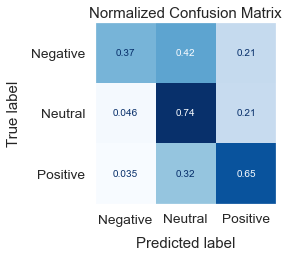

<IPython.core.display.Javascript object>

In [43]:
# Make copy of baseline for future reference
baseline = clone(main_pipe)

test_fit(main_pipe)

My `diag.test_fit` function has the handy ability to shuffle and re-split the data. It's important to remember that the diagnostics can differ quite a bit between splits, which is why it's necessary to use K-fold cross-validation when tuning hyperparameters.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.388,0.768,0.602,0.586,0.689,0.684,0.607
recall,0.468,0.754,0.598,0.607,0.684,,
f1-score,0.424,0.761,0.600,0.595,0.686,,
support,0.064,0.605,0.332,,,,


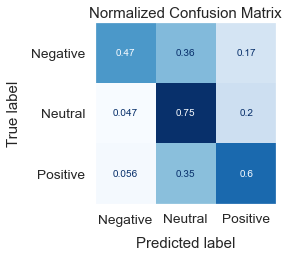

<IPython.core.display.Javascript object>

In [44]:
test_fit(main_pipe, resplit=True, random_state=485694)

### Compare with Dummy

The baseline, while crude, is much better than the dummy model. This `DummyClassifier` algorithm randomly selects classes with probability weighted according to the class balance. With this dataset, it almost never selects Negative, and it's a 60-30 split between Neutral and Positive.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.066,0.602,0.324,0.331,0.476,0.473,0.331
recall,0.078,0.605,0.310,0.331,0.473,,
f1-score,0.071,0.603,0.317,0.330,0.474,,
support,0.064,0.605,0.332,,,,


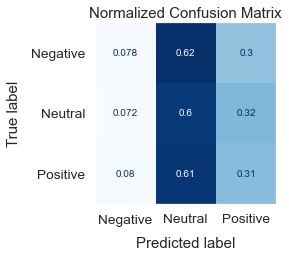

<IPython.core.display.Javascript object>

In [45]:
dummy = DummyClassifier(strategy="stratified", random_state=15)
dummy_pipe = clone(main_pipe).set_params(cls=dummy)
test_fit(dummy_pipe)

## Configure TF\*IDF

Rather than manually play with the TF\*IDF settings, I'm going to search the whole parameter space for the best parameters. Here I create a `partial` object which wraps my `selection.sweep` function and holds the data, scoring, and other settings in place (though they can be overridden).

<a id='my-sweep-function'></a>

### My `sweep` Function

My `selection.sweep` function is a generic function for searching parameter spaces using Scikit-Learn. If you pass `kind='grid'`, it fits a `GridSearchCV`, running an exhaustive search over every combination of parameters. This is the default (and most thorough) option. You can also pass `kind='rand'` to fit a `RandomizedSearchCV`, which searches a random sample of the parameter space. If you want to speed things up, you can pass `kind='hgrid'` or `kind='hrand'` to fit Scikit-Learn's experimental `HalvingGridSearchCV` or its randomized counterpart. The "halving" searches try to weed out the weak candidates using only a small amount of computational resources (e.g. a small sample of the data).

Rather than returning a `GridSearchCV` object or equivalent, `selection.sweep` immediately serializes the search estimator and saves it via `joblib`. This is done to prevent loss of the search results. It's very fast and easy to load a serialized search estimator, and I even have a function `selection.load_results` which trims down the `cv_results_` and returns a `DataFrame`.

In [46]:
sweep = partial(
    selection.sweep,
    X=X,
    y=y,
    scoring="balanced_accuracy",
    n_jobs=-1,
    cv=5,
    random_state=46,
)
sweep.keywords.keys()

dict_keys(['X', 'y', 'scoring', 'n_jobs', 'cv', 'random_state'])

<IPython.core.display.Javascript object>

I create a parameter grid for the TF\*IDF switches.

In [47]:
tfidf_grid = {
    "binary": [True, False],
    "norm": ["max", "l2", "l1", None],
    "smooth_idf": [True, False],
    "sublinear_tf": [True, False],
    "use_idf": [True, False],
}

tfidf_grid

{'binary': [True, False],
 'norm': ['max', 'l2', 'l1', None],
 'smooth_idf': [True, False],
 'sublinear_tf': [True, False],
 'use_idf': [True, False]}

<IPython.core.display.Javascript object>

One of the most convenient features of `selection.sweep` is that you can pass `add_prefix='col__txt__'` to add a prefix to all parameter names specified in the parameter grid. You'll see me using this a lot.

In [48]:
# sweep(main_pipe, tfidf_grid, add_prefix="col__txt__", dst="sweeps/txt_tfidf",)

<IPython.core.display.Javascript object>

As I said before, constructing document vectors with raw **term frequencies** is a very crude approach. Words like 'the', if not filtered out, will have a high frequency in many tweets. But 'the' contains no information about the tweet's overall content. The TF\*IDF algorithm addresses this problem by normalizing term frequencies according to **inverse document frequency**. A term's inverse document frequency is the (logarithmically scaled) number of documents in the corpus divided by the number of documents containing the term. It represents the rarity of a term.

In [49]:
results = selection.load_results("sweeps/txt_tfidf", drop_dicts=False)

# Hide param dicts for display
results.drop(columns="params").head(10).style.bar("mean_score")

,binary,norm,smooth_idf,sublinear_tf,use_idf,mean_fit_time,mean_score,rank_score
46,False,l2,False,False,True,1.916400,0.625642,1
44,False,l2,False,True,True,1.875801,0.625237,2
40,False,l2,True,True,True,1.909001,0.625119,3
42,False,l2,True,False,True,1.893202,0.624929,4
10,True,l2,True,False,True,2.011204,0.619733,5
8,True,l2,True,True,True,1.974603,0.619733,5
12,True,l2,False,True,True,2.025804,0.619416,7
14,True,l2,False,False,True,2.026598,0.619416,7
47,False,l2,False,False,False,2.023000,0.607776,9
43,False,l2,True,False,False,1.938000,0.607776,9


<IPython.core.display.Javascript object>

Looks like a noticeable increase in balanced accuracy (a.k.a. macro average recall) on the current split. That's a good sign. Positive recall is clearly much better, but Negative recall is still pretty low.

{'col__txt__binary': False,
 'col__txt__norm': 'l2',
 'col__txt__smooth_idf': False,
 'col__txt__sublinear_tf': False,
 'col__txt__use_idf': True}

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.316,0.799,0.575,0.563,0.694,0.665,0.611
recall,0.475,0.675,0.682,0.611,0.665,,
f1-score,0.380,0.732,0.624,0.579,0.674,,
support,0.064,0.605,0.332,,,,


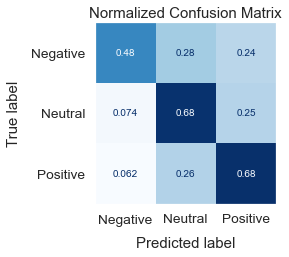

<IPython.core.display.Javascript object>

In [50]:
# Get params from search results and set them
main_pipe.set_params(**results.iloc[0].params)

# Show what I'm setting
display(results.iloc[0].params)

test_fit(main_pipe)

## Configure Logistic Regression

Now I run a search over the key `LogisticRegression` hyperparameters. This includes penalty type ('l1', 'l2'), regularization strength ('C'), multi-class strategy, whether to fit an intercept, and the solver.

In [51]:
logit_grid = [
    {
        "C": np.geomspace(1e-3, 1e3, 7),
        "fit_intercept": [True, False],
        "multi_class": ["multinomial", "ovr"],
        "solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "penalty": ["l2"],
    },
    {
        "C": np.geomspace(1e-3, 1e3, 7),
        "fit_intercept": [True, False],
        "multi_class": ["ovr"],
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
    },
]

logit_grid

[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'fit_intercept': [True, False],
  'multi_class': ['multinomial', 'ovr'],
  'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
  'penalty': ['l2']},
 {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'fit_intercept': [True, False],
  'multi_class': ['ovr'],
  'solver': ['liblinear'],
  'penalty': ['l1', 'l2']}]

<IPython.core.display.Javascript object>

Run the search.

In [52]:
# sweep(main_pipe, logit_grid, add_prefix="cls__", dst="sweeps/logit")

<IPython.core.display.Javascript object>

Looks like the winner is 'newton-cg' with no intercept and the default regularization settings. The 'newton-cg' solver is fast on this dataset.

In [53]:
results = selection.load_results("sweeps/logit", drop_dicts=False)

# Hide param dicts for display
results.drop(columns="params").head(10).style.bar("mean_score")

,C,fit_intercept,multi_class,penalty,solver,mean_fit_time,mean_score,rank_score
57,1.000000,False,multinomial,l2,newton-cg,1.040801,0.625643,1
48,1.000000,True,multinomial,l2,lbfgs,1.802003,0.625642,2
49,1.000000,True,multinomial,l2,newton-cg,1.225003,0.625642,2
56,1.000000,False,multinomial,l2,lbfgs,1.180398,0.625530,4
50,1.000000,True,multinomial,l2,sag,61.938400,0.619778,5
51,1.000000,True,multinomial,l2,saga,70.356597,0.619734,6
59,1.000000,False,multinomial,l2,saga,68.141198,0.618410,7
62,1.000000,False,ovr,l2,sag,35.855398,0.612832,8
63,1.000000,False,ovr,l2,saga,36.989198,0.612820,9
54,1.000000,True,ovr,l2,sag,38.938600,0.610127,10


<IPython.core.display.Javascript object>

The balanced accuracy got slightly lower, but that doesn't mean much. The `GridSearchCV` results are 5-fold cross-validated and are more reliable than the diagnostics from the current split.

{'cls__C': 1.0,
 'cls__fit_intercept': False,
 'cls__multi_class': 'multinomial',
 'cls__penalty': 'l2',
 'cls__solver': 'newton-cg'}

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.313,0.799,0.574,0.562,0.693,0.663,0.610
recall,0.475,0.672,0.683,0.610,0.663,,
f1-score,0.377,0.730,0.624,0.577,0.672,,
support,0.064,0.605,0.332,,,,


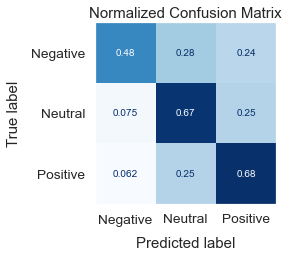

<IPython.core.display.Javascript object>

In [54]:
# Get params from search results and set them
main_pipe.set_params(**results.iloc[0].params)

# Show what I'm setting
display(results.iloc[0].params)

test_fit(main_pipe)

## Select Tokenizer

Now use my `sweep` function to run a grid search over a variety of tokenizers and stopword sets.

The callable tokenizers which I plan to test are in the cell below. The `WhiteSpaceTokenizer` is there as a baseline. NLTK's recommended word tokenizer is `nltk.word_tokenize`, but `nltk.TweetTokenizer` is another obvious one to try.

I've also thrown in some other tokenizers that are on the market. The difference between `nltk.word_tokenize` and `nltk.NLTKWordTokenizer` is that the former uses `nltk.sent_tokenize` before tokenizing words.

In [55]:
callable_tokenizers = [
    nltk.word_tokenize,
    nltk.TweetTokenizer().tokenize,
    nltk.NLTKWordTokenizer().tokenize,
    nltk.TreebankWordTokenizer().tokenize,
    nltk.ToktokTokenizer().tokenize,
    nltk.WhitespaceTokenizer().tokenize,
    MosesTokenizer().tokenize,
]
callable_tokenizers

[<function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>,
 <bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000001557AD69D60>>,
 <bound method NLTKWordTokenizer.tokenize of <nltk.tokenize.destructive.NLTKWordTokenizer object at 0x000001557AD69DC0>>,
 <bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x000001557AD69E20>>,
 <bound method ToktokTokenizer.tokenize of <nltk.tokenize.toktok.ToktokTokenizer object at 0x000001557AD69E50>>,
 <bound method RegexpTokenizer.tokenize of WhitespaceTokenizer(pattern='\\s+', gaps=True, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>,
 <bound method MosesTokenizer.tokenize of <sacremoses.tokenize.MosesTokenizer object at 0x000001557AD69EE0>>]

<IPython.core.display.Javascript object>

The following are tokenizing regular expressions which I plan to test. The first is the default expression in SKL's `CountVectorizer`, and the second is taken from `nltk.wordpunct_tokenizer`.

In [56]:
token_regexes = [r"(?u)\b\w\w+\b", r"\w+|[^\w\s]+"]
token_regexes

['(?u)\\b\\w\\w+\\b', '\\w+|[^\\w\\s]+']

<IPython.core.display.Javascript object>

The following are the stopwords sets I plan to test. It includes `my_stop`, a short list which I defined earlier. My `FreqVectorizer` is capable of fetching the a number of different stopwords sets given the relevant string argument. It's also capable of fielding complex queries that involve set operators like '|' (union) and '&' intersection.

In [57]:
stop_sets = [
    "skl_english",
    "nltk_english",
    "gensim_english",
    "skl_english | nltk_english | gensim_english",
    "skl_english & nltk_english & gensim_english",
    my_stop,
    brand_stop,
    my_stop | brand_stop,
    None,
]

# Pretty print to make compact
pprint(stop_sets, compact=True)

['skl_english', 'nltk_english', 'gensim_english',
 'skl_english | nltk_english | gensim_english',
 'skl_english & nltk_english & gensim_english',
 frozenset({'america', 'austin', 'link', 'mention', 'quot', 'rt',
            'southbysouthwest', 'sxsw', 'sxswi'}),
 frozenset({'andoid', 'android', 'androidsxsw', 'app', 'apple', 'applesxsw',
            'google', 'ipad', 'iphone'}),
 frozenset({'america', 'andoid', 'android', 'androidsxsw', 'app', 'apple',
            'applesxsw', 'austin', 'google', 'ipad', 'iphone', 'link',
            'mention', 'quot', 'rt', 'southbysouthwest', 'sxsw', 'sxswi'}),
 None]


<IPython.core.display.Javascript object>

Here is the parameter grid which will be passed to `GridSearchCV` (after the proper prefix is added by my `sweep` function).

In [58]:
tokenizer_grid = [
    # Grid for callable tokenizers
    {
        "tokenizer": callable_tokenizers,
        "token_pattern": [None],
        "stop_words": stop_sets,
    },
    # Grid for patterns
    {
        "tokenizer": [None],
        "token_pattern": token_regexes,
        "stop_words": stop_sets,
    },
]

pprint(tokenizer_grid[1], compact=True)

{'stop_words': ['skl_english', 'nltk_english', 'gensim_english',
                'skl_english | nltk_english | gensim_english',
                'skl_english & nltk_english & gensim_english',
                frozenset({'america', 'austin', 'link', 'mention', 'quot', 'rt',
                           'southbysouthwest', 'sxsw', 'sxswi'}),
                frozenset({'andoid', 'android', 'androidsxsw', 'app', 'apple',
                           'applesxsw', 'google', 'ipad', 'iphone'}),
                frozenset({'america', 'andoid', 'android', 'androidsxsw', 'app',
                           'apple', 'applesxsw', 'austin', 'google', 'ipad',
                           'iphone', 'link', 'mention', 'quot', 'rt',
                           'southbysouthwest', 'sxsw', 'sxswi'}),
                None],
 'token_pattern': ['(?u)\\b\\w\\w+\\b', '\\w+|[^\\w\\s]+'],
 'tokenizer': [None]}


<IPython.core.display.Javascript object>

Run the sweep, adding the necessary prefix.

In [59]:
# sweep(
#     main_pipe,
#     tokenizer_grid,
#     add_prefix="col__txt__",
#     dst="sweeps/tokenizer",
#     kind="grid",
# )

<IPython.core.display.Javascript object>

And the winners are the regex pattern from `nltk.wordpunct_tokenize` and `my_stop`. This regex pattern is also considerably faster than the second best option of `nltk.word_tokenize`.

In [60]:
results = selection.load_results("sweeps/tokenizer")
results.tokenizer = results.tokenizer.map(str).map(lang.strip_punct)
results.head(10).style.bar("mean_score")

,stop_words,token_pattern,tokenizer,mean_fit_time,mean_score,rank_score
74,"frozenset({'southbysouthwest', 'rt', 'link', 'sxsw', 'sxswi', 'mention', 'austin', 'america', 'quot'})",\w+|[^\w\s]+,None,1.180000,0.637274,1
78,"frozenset({'andoid', 'applesxsw', 'rt', 'southbysouthwest', 'link', 'sxsw', 'sxswi', 'mention', 'android', 'austin', 'iphone', 'app', 'america', 'google', 'apple', 'ipad', 'androidsxsw', 'quot'})",\w+|[^\w\s]+,None,1.160600,0.637140,2
80,None,\w+|[^\w\s]+,None,1.063597,0.637046,3
76,"frozenset({'andoid', 'applesxsw', 'android', 'iphone', 'app', 'apple', 'google', 'ipad', 'androidsxsw'})",\w+|[^\w\s]+,None,1.199600,0.635244,4
35,"frozenset({'southbysouthwest', 'rt', 'link', 'sxsw', 'sxswi', 'mention', 'austin', 'america', 'quot'})",None,function word tokenize at 0x000001556B3330D0,3.369200,0.634900,5
56,None,None,function word tokenize at 0x000001556B3330D0,3.827400,0.634744,6
72,skl_english & nltk_english & gensim_english,\w+|[^\w\s]+,None,1.193000,0.634232,7
49,"frozenset({'andoid', 'applesxsw', 'rt', 'southbysouthwest', 'link', 'sxsw', 'sxswi', 'mention', 'android', 'austin', 'iphone', 'app', 'america', 'google', 'apple', 'ipad', 'androidsxsw', 'quot'})",None,function word tokenize at 0x000001556B3330D0,3.264600,0.633011,8
50,"frozenset({'andoid', 'applesxsw', 'rt', 'southbysouthwest', 'link', 'sxsw', 'sxswi', 'mention', 'android', 'austin', 'iphone', 'app', 'america', 'google', 'apple', 'ipad', 'androidsxsw', 'quot'})",None,bound method TweetTokenizer tokenize of nltk tokenize casual TweetTokenizer object at 0x000001557AE2C430,1.924601,0.632183,9
42,"frozenset({'andoid', 'applesxsw', 'android', 'iphone', 'app', 'apple', 'google', 'ipad', 'androidsxsw'})",None,function word tokenize at 0x000001556B3330D0,3.300199,0.632038,10


<IPython.core.display.Javascript object>

Looks like a noticeable improvement on the current split, although negative recall is still much lower than I'd like.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.309,0.812,0.594,0.572,0.708,0.677,0.624
recall,0.489,0.684,0.700,0.624,0.677,,
f1-score,0.379,0.742,0.643,0.588,0.686,,
support,0.064,0.605,0.332,,,,


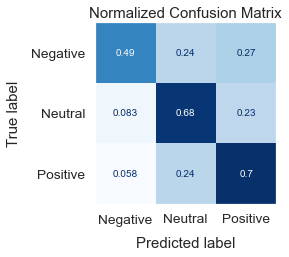

<IPython.core.display.Javascript object>

In [61]:
main_pipe.set_params(
    col__txt__token_pattern=r"\w+|[^\w\s]+",
    col__txt__stop_words=my_stop,
)
test_fit(main_pipe)

## Select Text Preprocessors

Next I load up my pre-made parameter grid for text preprocessors. My `FreqVectorizer`, which extends `TfidfVectorizer`, has several additional preprocessing options. It can:

- Strip Punctuation (`strip_punct=True`)
- Strip Numerals (`strip_numeric=True`)
- Split Up Alphanumeric Sequences (`split_alphanum=True`)
- Force Only Alphanumeric (`alphanum_only=True`)
- Strip Twitter Handles (`strip_twitter_handles=True`)
- Limit Repeating Characters (`limit_repeats=True`)
- Porter Stem Words (`stemmer='porter'`)
- Lemmatize Words with Wordnet (`stemmer='wordnet'`)

Like its parent class, it can also strip unicode accents (`strip_accents='unicode'`), or strip all unicode characters (`strip_accents='ascii'`).

In [62]:
preproc_grid = {
    "lowercase": [True, False],
    "strip_multiwhite": [True, False],
    "strip_punct": [True, False],
    "strip_numeric": [True, False],
    "split_alphanum": [True, False],
    "alphanum_only": [True, False],
    "strip_twitter_handles": [True, False],
    "limit_repeats": [True, False],
    "strip_accents": ["unicode", "ascii", None],
    "stemmer": ["porter", "wordnet", None],
}

preproc_grid

{'lowercase': [True, False],
 'strip_multiwhite': [True, False],
 'strip_punct': [True, False],
 'strip_numeric': [True, False],
 'split_alphanum': [True, False],
 'alphanum_only': [True, False],
 'strip_twitter_handles': [True, False],
 'limit_repeats': [True, False],
 'strip_accents': ['unicode', 'ascii', None],
 'stemmer': ['porter', 'wordnet', None]}

<IPython.core.display.Javascript object>

Run the sweep.

In [63]:
# sweep(
#     main_pipe,
#     preproc_grid,
#     add_prefix="col__txt__",
#     kind="grid",
#     dst="sweeps/text_preproc",
# )

<IPython.core.display.Javascript object>

Now I load up the results. Looks like `stemmer='wordnet'`, `split_alphanum=True`, and `strip_accents='ascii'` are the only winners which are not default settings.

In [64]:
# Load with param dicts
results = selection.load_results("sweeps/text_preproc", drop_dicts=False)

# Hide dicts for display
results.drop(columns="params").head(10).style.bar("mean_score")

,alphanum_only,limit_repeats,lowercase,split_alphanum,stemmer,strip_accents,strip_multiwhite,strip_numeric,strip_punct,strip_twitter_handles,mean_fit_time,mean_score,rank_score
1807,False,False,True,True,wordnet,ascii,False,False,False,False,1.411202,0.645545,1
1223,False,True,True,True,wordnet,ascii,True,False,False,False,2.166000,0.645545,1
1231,False,True,True,True,wordnet,ascii,False,False,False,False,1.567802,0.645545,1
1799,False,False,True,True,wordnet,ascii,True,False,False,False,1.546001,0.645545,1
1215,False,True,True,True,wordnet,unicode,False,False,False,False,3.851801,0.644395,5
1207,False,True,True,True,wordnet,unicode,True,False,False,False,11.311922,0.644395,5
1783,False,False,True,True,wordnet,unicode,True,False,False,False,1.593202,0.644395,5
1791,False,False,True,True,wordnet,unicode,False,False,False,False,1.418802,0.644395,5
1319,False,True,True,False,porter,ascii,True,False,False,False,1.378600,0.644229,9
1895,False,False,True,False,porter,ascii,True,False,False,False,1.396799,0.644229,9


<IPython.core.display.Javascript object>

It's a minor improvement on the current split. Nonetheless, it's the `GridSearchCV` results that matter most.

{'col__txt__alphanum_only': False,
 'col__txt__limit_repeats': False,
 'col__txt__lowercase': True,
 'col__txt__split_alphanum': True,
 'col__txt__stemmer': 'wordnet',
 'col__txt__strip_accents': 'ascii',
 'col__txt__strip_multiwhite': False,
 'col__txt__strip_numeric': False,
 'col__txt__strip_punct': False,
 'col__txt__strip_twitter_handles': False}

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.311,0.808,0.583,0.567,0.702,0.667,0.626
recall,0.518,0.669,0.692,0.626,0.667,,
f1-score,0.388,0.732,0.633,0.584,0.677,,
support,0.064,0.605,0.332,,,,


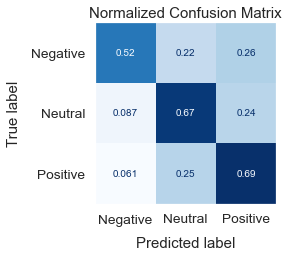

<IPython.core.display.Javascript object>

In [65]:
# Set with best params in `results`
main_pipe.set_params(**results.iloc[0].params)

# Show the params to confirm
display(results.iloc[0].params)

test_fit(main_pipe)

The text looks ugly, but apparently this leads to the best models.

In [66]:
analyzer = col_xform.named_transformers_["txt"].build_analyzer()
X.text.map(analyzer)

0       [.@, wesley, 83, i, have, a, 3, g, iphone, ., ...
1       [@, jessedee, know, about, @, fludapp, ?, awes...
2       [@, swonderlin, can, not, wait, for, #, ipad, ...
3       [@, i, hope, this, year, ', s, festival, isn, ...
4       [@, sxtxstate, great, stuff, on, fri, #, :, ma...
                              ...                        
9088                       [ipad, everywhere, ., #, {, }]
9089    [wave, ,, buzz, ..., @, we, interrupt, your, r...
9090    [google, ', s, zeiger, ,, a, physician, never,...
9091    [some, verizon, iphone, customer, complain, th...
9092    [___rt, @, google, test, check, -, in, offer, ...
Name: text, Length: 8879, dtype: object

<IPython.core.display.Javascript object>

In addition to its other preprocessing options, `FreqVectorizer` has word-marking capabilities. It can mark words between a negating term and a punctuation mark with a suffix (`mark='neg'`). For example,

> "I don't like dolphins."

would become

> "I don't like_NEG dolphins_NEG."

It can likewise tag words with their part of speech (`mark='speech'`). If `mark='neg_split'` or `mark='speech_split'` is set, the markers are broken off into separate tokens. Since `FreqVectorizer` effectively treats each document as a bag-of-words (i.e. ignores word order), turning the markers into independent tokens can have an interesting effect. To really change things up, `mark='speech_replace'` replaces words with their PoS tags.

In [67]:
mark_grid = {
    "mark": [
        "neg",
        "speech",
        "neg_split",
        "speech_split",
        "speech_replace",
        None,
    ]
}
mark_grid

{'mark': ['neg',
  'speech',
  'neg_split',
  'speech_split',
  'speech_replace',
  None]}

<IPython.core.display.Javascript object>

Run the sweep.

In [68]:
# sweep(
#     main_pipe,
#     mark_grid,
#     add_prefix="col__txt__",
#     dst="sweeps/mark",
# )

<IPython.core.display.Javascript object>

In this case, it looks like no marker is preferred.

In [69]:
selection.load_results("sweeps/mark").style.bar("mean_score")

,mark,mean_fit_time,mean_score,rank_score
5,None,1.395799,0.645545,1
0,neg,24.310201,0.641165,2
2,neg_split,1.664400,0.641100,3
3,speech_split,18.626800,0.639235,4
1,speech,31.867000,0.613321,5
4,speech_replace,17.280222,0.493256,6


<IPython.core.display.Javascript object>

## Cap Token Length

I run a search for minimum and maximum word-token character length.

In [70]:
length_grid = utils.cartesian([0, 2, 3, 5], [None, 10, 15, 20, 30])
length_grid = {"filter_length": length_grid.tolist()}
length_grid

{'filter_length': [[0, None],
  [0, 10],
  [0, 15],
  [0, 20],
  [0, 30],
  [2, None],
  [2, 10],
  [2, 15],
  [2, 20],
  [2, 30],
  [3, None],
  [3, 10],
  [3, 15],
  [3, 20],
  [3, 30],
  [5, None],
  [5, 10],
  [5, 15],
  [5, 20],
  [5, 30]]}

<IPython.core.display.Javascript object>

Run the sweep.

In [71]:
# sweep(
#     main_pipe,
#     length_grid,
#     add_prefix="col__txt__",
#     dst="sweeps/filter_length",
# )

<IPython.core.display.Javascript object>

Looks like the best option is to cap token length at 20 characters.

In [72]:
results = selection.load_results("sweeps/filter_length")
results.head(10).style.bar("mean_score")

,filter_length,mean_fit_time,mean_score,rank_score
3,"[0, 20]",1.481400,0.645607,1
0,"[0, None]",1.488201,0.645545,2
4,"[0, 30]",1.607799,0.645545,2
2,"[0, 15]",1.619800,0.644613,4
1,"[0, 10]",5.336200,0.642801,5
9,"[2, 30]",1.318401,0.633151,6
5,"[2, None]",17.659800,0.633151,6
7,"[2, 15]",2.868200,0.633024,8
8,"[2, 20]",2.090000,0.632976,9
6,"[2, 10]",12.392601,0.632449,10


<IPython.core.display.Javascript object>

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.312,0.809,0.583,0.568,0.702,0.668,0.626
recall,0.518,0.670,0.692,0.626,0.668,,
f1-score,0.389,0.733,0.633,0.585,0.678,,
support,0.064,0.605,0.332,,,,


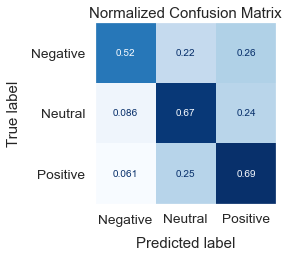

<IPython.core.display.Javascript object>

In [73]:
main_pipe.set_params(col__txt__filter_length=(0, 20))
test_fit(main_pipe)

## Select Default N-Grams

I run a search over the 'ngram_range' settings. Unfortunately, `FreqVectorizer`, like its parent class, only searches for n-grams locally within each document.

In [74]:
# Create broad parameter space
ngram_grid = utils.cartesian(np.arange(1, 5), np.arange(1, 5))

# Slice out only valid ngram ranges
ngram_grid = ngram_grid[ngram_grid[:, 0] <= ngram_grid[:, 1]]
ngram_grid = {"ngram_range": ngram_grid.tolist()}
ngram_grid

{'ngram_range': [[1, 1],
  [1, 2],
  [1, 3],
  [1, 4],
  [2, 2],
  [2, 3],
  [2, 4],
  [3, 3],
  [3, 4],
  [4, 4]]}

<IPython.core.display.Javascript object>

In [75]:
# sweep(main_pipe, ngram_grid, add_prefix="col__txt__", dst="sweeps/ngram_range")

<IPython.core.display.Javascript object>

The default wins.

In [76]:
selection.load_results("sweeps/ngram_range").style.bar("mean_score")

,ngram_range,mean_fit_time,mean_score,rank_score
0,"[1, 1]",22.615603,0.643613,1
1,"[1, 2]",21.319400,0.611675,2
2,"[1, 3]",32.919000,0.605521,3
3,"[1, 4]",58.851199,0.601133,4
4,"[2, 2]",10.879796,0.585839,5
5,"[2, 3]",32.045599,0.575929,6
6,"[2, 4]",55.868197,0.571970,7
7,"[3, 3]",19.511798,0.558619,8
8,"[3, 4]",42.536200,0.551814,9
9,"[4, 4]",19.802000,0.535158,10


<IPython.core.display.Javascript object>

## Select Default DF

Sweep document frequency limits and max features.

In [77]:
df_grid = {
    "min_df": [1, 5, 10, 20],
    "max_df": [0.2, 0.4, 0.6, 0.8, 1.0],
    "max_features": [300, 3000, None],
}
display(df_grid)

# sweep(
#     main_pipe,
#     df_grid,
#     add_prefix="col__txt__",
#     dst="sweeps/doc_frequency",
#     kind="grid",
# )

{'min_df': [1, 5, 10, 20],
 'max_df': [0.2, 0.4, 0.6, 0.8, 1.0],
 'max_features': [300, 3000, None]}

<IPython.core.display.Javascript object>

The defaults win.

In [78]:
selection.load_results("sweeps/doc_frequency").head(10).style.bar("mean_score")

,max_df,max_features,min_df,mean_fit_time,mean_score,rank_score
56,1.000000,nan,1,1.919801,0.643613,1
44,0.800000,nan,1,1.780403,0.640246,2
32,0.600000,nan,1,1.833805,0.640246,2
52,1.000000,3000.000000,1,1.512602,0.639883,4
20,0.400000,nan,1,1.811401,0.638131,5
28,0.600000,3000.000000,1,1.453402,0.637789,6
40,0.800000,3000.000000,1,1.451200,0.637789,6
4,0.200000,3000.000000,1,1.396802,0.637252,8
8,0.200000,nan,1,2.051401,0.635479,9
16,0.400000,3000.000000,1,1.411001,0.633837,10


<IPython.core.display.Javascript object>

<a id='add-vadervectorizer'></a>

## Add `VaderVectorizer`

I add a new vectorizer to the mix which performs VADER sentiment analysis on each tweet and returns the polarity scores as vectors.

In [79]:
col_xform.transformers.append(("vad", VaderVectorizer(), "text"))
col_xform

ColumnTransformer(transformers=[('txt',
                                 FreqVectorizer(filter_length=(0, 20),
                                                norm='l2', smooth_idf=False,
                                                split_alphanum=True,
                                                stemmer='wordnet',
                                                stop_words=frozenset({'america',
                                                                      'austin',
                                                                      'link',
                                                                      'mention',
                                                                      'quot',
                                                                      'rt',
                                                                      'southbysouthwest',
                                                                      'sxsw',
                                  

<IPython.core.display.Javascript object>

Looks like a sizable increase in balanced accuracy by just adding 4 new features. The next order of business is to configure the `VaderVectorizer` hyperparameters.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.335,0.809,0.603,0.582,0.710,0.681,0.644
recall,0.553,0.689,0.690,0.644,0.681,,
f1-score,0.417,0.744,0.643,0.601,0.690,,
support,0.064,0.605,0.332,,,,


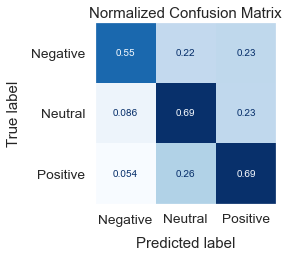

<IPython.core.display.Javascript object>

In [80]:
test_fit(main_pipe)

In [81]:
vader_grid = {
    "trinarize": [True, False],
    "compound": [True, False],
    "category": [True, False],
    "norm": ["l1", "l2", "max", None],
}

vader_grid

{'trinarize': [True, False],
 'compound': [True, False],
 'category': [True, False],
 'norm': ['l1', 'l2', 'max', None]}

<IPython.core.display.Javascript object>

In [82]:
# sweep(
#     main_pipe,
#     vader_grid,
#     add_prefix="col__vad__",
#     dst="sweeps/vader_switches",
# )

<IPython.core.display.Javascript object>

Looks like the best settings are to use only the categories ("pos", "neu" and "neg"), trinarize them (get sign indicators -1, 0, or 1), and use L2 normalization.

In [83]:
results = selection.load_results("sweeps/vader_switches", drop_dicts=False)
results.drop(columns="params").head(10).style.bar("mean_score")

,category,compound,norm,trinarize,mean_fit_time,mean_score,rank_score
8,True,False,l1,True,3.595721,0.653153,1
0,True,True,l1,True,28.691401,0.652239,2
10,True,False,l2,True,2.850402,0.651400,3
14,True,False,None,True,2.495801,0.651137,4
12,True,False,max,True,2.461203,0.651137,4
4,True,True,max,True,2.724204,0.650838,6
6,True,True,None,True,2.766199,0.650838,6
2,True,True,l2,True,2.428202,0.650692,8
5,True,True,max,False,2.657401,0.650677,9
7,True,True,None,False,3.251200,0.649078,10


<IPython.core.display.Javascript object>

It's a major improvement. But now I have 3 vectorizers, each with a different normalization setting. It's time to run a sweep on all of the normalization settings together.

{'col__vad__category': True,
 'col__vad__compound': False,
 'col__vad__norm': 'l1',
 'col__vad__trinarize': True}

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.333,0.815,0.599,0.582,0.713,0.678,0.650
recall,0.567,0.674,0.708,0.650,0.678,,
f1-score,0.420,0.738,0.649,0.602,0.688,,
support,0.064,0.605,0.332,,,,


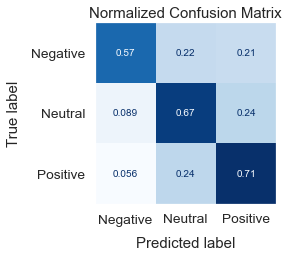

<IPython.core.display.Javascript object>

In [84]:
# Get params from search results and set them
main_pipe.set_params(**results.iloc[0].params)

# Show what I'm setting
display(results.iloc[0].params)

test_fit(main_pipe)

## Optimize Normalization

Next I add a `Normalizer` as the second to last step in `main_pipe`. It comes just before the classifier. Now I can tune each vectorizer's norm plus the global norm setting.

In [85]:
main_pipe.steps.insert(-1, ("norm", Normalizer()))
main_pipe

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt',
                                                  FreqVectorizer(filter_length=(0,
                                                                                20),
                                                                 norm='l2',
                                                                 smooth_idf=False,
                                                                 split_alphanum=True,
                                                                 stemmer='wordnet',
                                                                 stop_words=frozenset({'america',
                                                                                       'austin',
                                                                                       'link',
                                                                                       'mention',
                                  

<IPython.core.display.Javascript object>

I create a parameter grid with all the normalization options.

In [86]:
norm_grid = [
    {
        "col__txt__norm": ["l1", "l2", "max", None],
        "col__bra__norm": ["l1", "l2", "max", None],
        "col__vad__norm": ["l1", "l2", "max", None],
        "norm__norm": ["l1", "l2", "max"],
        "norm": [Normalizer()],
    },
    {
        "col__txt__norm": ["l1", "l2", "max", None],
        "col__bra__norm": ["l1", "l2", "max", None],
        "col__vad__norm": ["l1", "l2", "max", None],
        "norm": ["passthrough"],
    },
]
norm_grid

[{'col__txt__norm': ['l1', 'l2', 'max', None],
  'col__bra__norm': ['l1', 'l2', 'max', None],
  'col__vad__norm': ['l1', 'l2', 'max', None],
  'norm__norm': ['l1', 'l2', 'max'],
  'norm': [Normalizer()]},
 {'col__txt__norm': ['l1', 'l2', 'max', None],
  'col__bra__norm': ['l1', 'l2', 'max', None],
  'col__vad__norm': ['l1', 'l2', 'max', None],
  'norm': ['passthrough']}]

<IPython.core.display.Javascript object>

Run the sweep.

In [87]:
# sweep(
#     test_pipe,
#     norm_grid,
#     dst="sweeps/norms",
# )

<IPython.core.display.Javascript object>

The best combination seems kind of ad hoc and unsystematic, but the `GridSearchCV` has spoken.

In [88]:
results = selection.load_results(
    "sweeps/norms",
    short_names=False,
    drop_dicts=False,
)

# Hide dictionaries for display
results.drop(columns="params").head()

,param_col__bra__norm,param_col__txt__norm,param_col__vad__norm,param_norm,param_norm__norm,mean_fit_time,mean_test_score,rank_test_score
82,l2,max,None,Normalizer(),l2,2.223402,0.655028,1
79,l2,max,max,Normalizer(),l2,2.126800,0.655028,1
76,l2,max,l2,Normalizer(),l2,2.149799,0.653813,3
31,l1,max,max,Normalizer(),l2,2.127201,0.653656,4
34,l1,max,None,Normalizer(),l2,2.137000,0.653656,4


<IPython.core.display.Javascript object>

I must say... the odd combination of settings has noticeably improved the model.

{'col__bra__norm': 'l2',
 'col__txt__norm': 'max',
 'col__vad__norm': None,
 'norm': Normalizer(),
 'norm__norm': 'l2'}

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.328,0.821,0.600,0.583,0.717,0.676,0.665
recall,0.624,0.664,0.707,0.665,0.676,,
f1-score,0.430,0.734,0.649,0.605,0.687,,
support,0.064,0.605,0.332,,,,


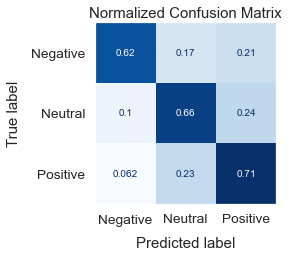

<IPython.core.display.Javascript object>

In [89]:
# Get params from search results and set them
main_pipe.set_params(**results.iloc[0].params)

# Show what I'm setting
display(results.iloc[0].params)

test_fit(main_pipe)

Save final confusion matrix for the presentation.

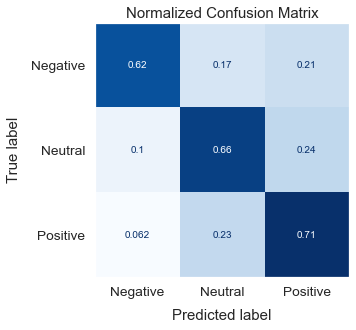

<IPython.core.display.Javascript object>

In [90]:
fig = diag.classification_plots(
    main_pipe.fit(X_train, y_train), X_test, y_test, pos_label="Positive"
)
fig.savefig(normpath("images/final_confusion_matrix.svg"))

## Final Model

After considerable experimentation and engineering, the final model's balanced accuracy of 0.665 vastly surpasses that of the baseline (0.587). I've reproduced the baseline below, for reference.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.371,0.774,0.605,0.584,0.693,0.689,0.587
recall,0.369,0.745,0.648,0.587,0.689,,
f1-score,0.370,0.759,0.626,0.585,0.690,,
support,0.064,0.605,0.332,,,,


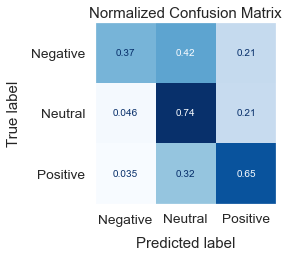

<IPython.core.display.Javascript object>

In [110]:
test_fit(baseline)

I began by configuring the TF\*IDF settings on my `FreqVectorizer`, because by default it is set for count vectorization. I proceeded to configure the `LogisticRegression` parameters, because the classifer parameters are of fundamental importance. 

After configuring the main vectorizer and classifer, I put considerable effort into trying to optimize the text preprocessing parameters. The most important decision was the choice of tokenizer. Choosing the tokenizer was relatively quick and easy compared to the other preprocessing parameters, such as the numerous filters, and stemming options, n-gram range, and token length limits. Choosing these other preprocessing parameters was very computationally demanding and the benefits were thin.

Fortunately, adding `VaderVectorizer` to the mix resulted in a substantial improvement. This makes sense, since training the model on the output of another sentiment analysis algorithm gives it access to new information and a new perspective. Then, since I had 3 vectorizers with different normalization settings, it made sense to optimize all of those settings together with a global norm setting. This proved to be well worth the time, and is a step I will repeat in the future.

,Negative,Neutral,Positive,macro avg,weighted avg,accuracy,bal accuracy
precision,0.328,0.821,0.600,0.583,0.717,0.676,0.665
recall,0.624,0.664,0.707,0.665,0.676,,
f1-score,0.430,0.734,0.649,0.605,0.687,,
support,0.064,0.605,0.332,,,,


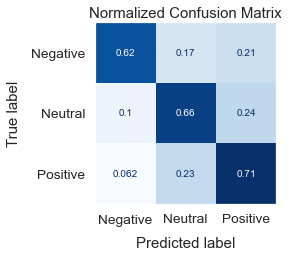

<IPython.core.display.Javascript object>

In [108]:
test_fit(main_pipe)

The final model has very high positive recall (0.71), but could do better on negative recall (0.62). Nevertheless, this dataset is very small and noisy, and I think the model turned out well. My thoughts are now on using `StackingClassifier` or a similar device to combine the outputs of more than one classifier. Synthesizing multiple perspectives on the data is likely to lead to even better accuracy.

## Refit with Final Parameters

In [92]:
main_pipe.fit(X, y)

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt',
                                                  FreqVectorizer(filter_length=(0,
                                                                                20),
                                                                 norm='max',
                                                                 smooth_idf=False,
                                                                 split_alphanum=True,
                                                                 stemmer='wordnet',
                                                                 stop_words=frozenset({'america',
                                                                                       'austin',
                                                                                       'link',
                                                                                       'mention',
                                 

<IPython.core.display.Javascript object>

# Interpretation

The first order of business is to label the coefficients.

In [93]:
feat_names = col_xform.get_feature_names()
classes = main_pipe["cls"].classes_
coef = pd.DataFrame(main_pipe["cls"].coef_, columns=feat_names, index=classes).T
coef.rename({"bra__": "bra__none"}, inplace=True)
coef.sort_values("Negative", ascending=False)

,Negative,Neutral,Positive
txt__headache,3.956535,-1.783098,-2.173436
txt__fail,3.736494,-1.959912,-1.776582
txt__t,3.190902,-1.417744,-1.773158
txt__not,2.944980,-1.043570,-1.901410
txt__long,2.719782,-1.090508,-1.629274
...,...,...,...
txt__at,-2.112503,1.453323,0.659180
txt__amp,-2.217913,2.142969,0.074944
txt__{,-2.318073,1.557367,0.760706
txt__},-2.376548,1.542267,0.834281


<IPython.core.display.Javascript object>

## Top 25 Overall
Then I examine the 25 coefficients with the largest magnitude.

In [94]:
top25 = coef.abs().max(axis=1).sort_values().tail(25).index
top25

Index(['txt__button', 'txt__at', 'txt__fuck', 'txt__crash', 'txt__amp',
       'txt__because', 'txt__great', 'txt__{', 'txt__?', 'txt__}', 'txt__fade',
       'txt__battery', 'vad__neg', 'txt__love', 'txt__hate', 'txt__delete',
       'txt__cool', 'txt__suck', 'txt__long', 'txt__not', 'txt__t', 'txt__!',
       'txt__fail', 'txt__headache', 'bra__none'],
      dtype='object')

<IPython.core.display.Javascript object>

Most of the top 25 coefficients are from the TF\*IDF word vectors, unsurprisingly. As predicted, '!' and '?' show up. I believe the letter 't' is what remains when certain contractions are broken up, and that's why it ranks high. The empty brand term category is very strongly related to 'Neutral'.

'images\\top25_coef.svg'

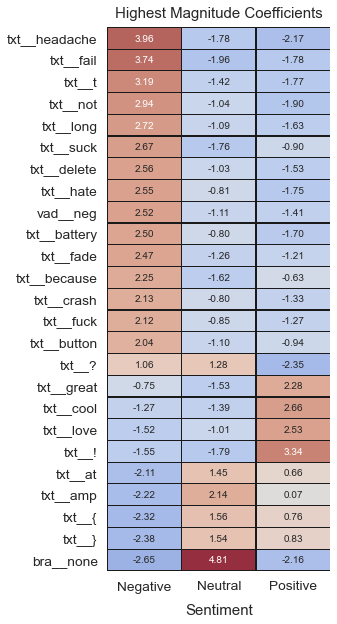

<IPython.core.display.Javascript object>

In [95]:
fig, ax = plt.subplots(figsize=(4, 10))
hm_style = dict(plotting.HEATMAP_STYLE)
del hm_style["square"]

sns.heatmap(
    coef.loc[top25].sort_values("Negative", ascending=False),
    ax=ax,
    square=False,
    **hm_style,
)

ax.set(xlabel="Sentiment")
ax.set_title("Highest Magnitude Coefficients", pad=10)
plotting.save(fig, "images/top25_coef.svg")

Interesting that the largest overall coefficient is for 'Negative'. Also the maxima are greater in magnitude than the minima.

<AxesSubplot:>

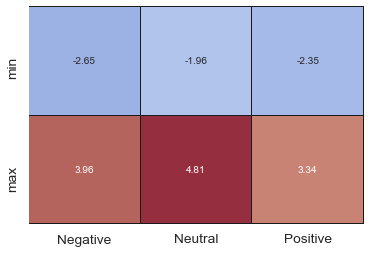

<IPython.core.display.Javascript object>

In [96]:
sns.heatmap(
    coef.agg(["min", "max"]),
    square=False,
    **hm_style,
)

I create a function for grabbing and formatting subsets of the coefficients.

In [97]:
def get_coefs(
    prefix,
    index_name,
    coef=coef,
    titlecase=True,
    icase=False,
):
    data = coef.filter(like=f"{prefix}__", axis=0)

    # Remove prefix
    data.index = data.index.str.replace("\w+__", "", regex=True)

    # Make snake_case titlecase
    data.index.name = index_name
    if titlecase:
        data = utils.title_mode(data)
        if icase:
            data.index = data.index.str.replace("Ip", "iP")
    return data.sort_values("Positive")

<IPython.core.display.Javascript object>

## TF\*IDF Words
The TF\*IDF features were the most influential overall, but they are not the most useful for brand-related insights.
See my EDA notebook ([exploratory.ipynb](exploratory.ipynb)) for a deeper brand-related examination of TF\*IDF keywords.

The terms in both the 'Positive' and 'Negative' wordclouds make very good sense, and many of them show up in the EDA wordclouds.

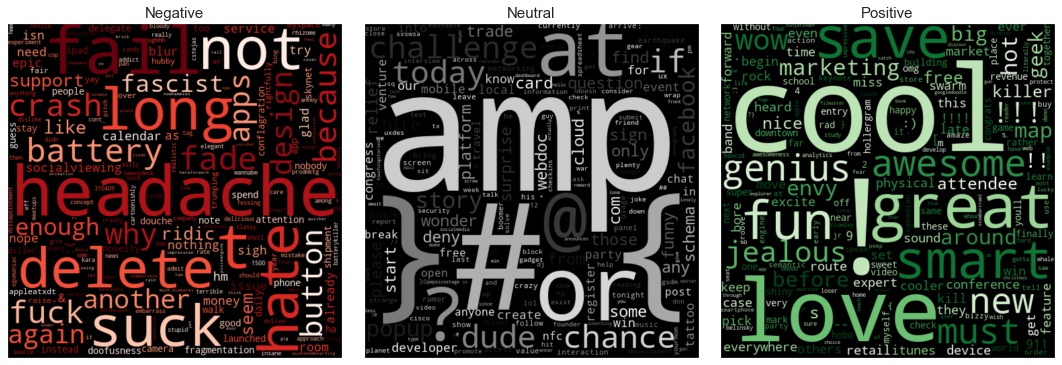

<IPython.core.display.Javascript object>

In [98]:
text_coef = get_coefs("txt", "Text", titlecase=False)

fig = plotting.wordcloud(
    text_coef,
    cmap=dict(Negative="Reds", Neutral="Greys", Positive="Greens"),
    size=(5, 5),
    random_state=rando,
)
fig.savefig(normpath("images/txt_coef_wordclouds.svg"), bbox_inches="tight")

## Brand Terms
Here are all the brand term coefficients. Remember that these are not TF\*IDF features. I extracted these with regular expressions and encoded their presence or absence in each tweet using `CountVectorizer(binary=True)`. These can be thought of like one-hot-encoded categorical variables.

In [99]:
brand_coef = get_coefs("bra", "Brand", icase=True)
brand_coef.index = ["None"] + brand_coef.index.to_list()[1:]
brand_coef

,Negative,Neutral,Positive
None,-2.653110,4.811004,-2.157894
iPhone,0.872490,-0.473306,-0.399184
Google,0.204135,-0.168952,-0.035183
Apple,0.324732,-0.559773,0.235041
Android,-0.569991,0.250564,0.319427
Android App,0.233400,-0.591197,0.357797
iPhone App,0.142423,-0.913528,0.771106
iPad,-0.409166,-0.597118,1.006284
iPad App,-0.939152,-0.150514,1.089666


<IPython.core.display.Javascript object>

A heatmap is one good way to visualize these coefficients. Unfortunately, it doesn't always bring out the see-saw-like patterns, where a brand term has a positive relationship with one class and a negative relationship with the opposite class.

'images\\brand_term_coef.svg'

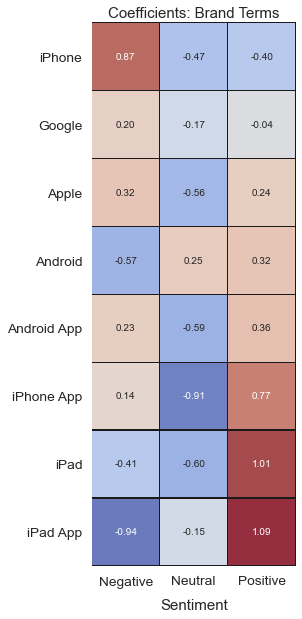

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(figsize=(4, 10))
hm_style = dict(plotting.HEATMAP_STYLE)
del hm_style["square"]

if "None" in brand_coef.index:
    brand_coef.drop("None", inplace=True)

sns.heatmap(brand_coef.sort_values("Positive"), ax=ax, square=True, **hm_style)

ax.set(xlabel="Sentiment", title="Coefficients: Brand Terms")
plotting.save(fig, "images/brand_term_coef.svg")

<AxesSubplot:>

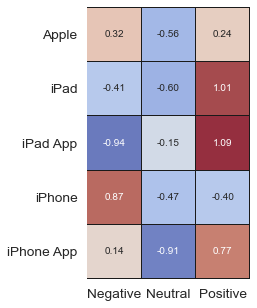

<IPython.core.display.Javascript object>

In [101]:
fig, ax = plt.subplots(figsize=(4, 5))

apple_rows = ["Apple", "iPad", "iPhone", "iPad App", "iPhone App"]

sns.heatmap(
    brand_coef.loc[apple_rows].sort_index(),
    ax=ax,
    square=True,
    **hm_style,
)

In [102]:
emo_pal = dict(Negative="r", Neutral="gray", Positive="g")
emo_pal

{'Negative': 'r', 'Neutral': 'gray', 'Positive': 'g'}

<IPython.core.display.Javascript object>

I create a useful function for making positive vs. negative coefficient plots.

In [103]:
def pos_neg_catplot(
    coefs,
    name=None,
    drop_neutral=True,
    palette=emo_pal,
    col_wrap=4,
    sup_y=1.05,
    annot_dist=0.15,
    annot_pad=0.025,
    height=3,
):
    if drop_neutral:
        coefs = coefs.drop("Neutral", axis=1)

    # Plot bars on FacetGrid
    g = sns.catplot(
        data=coefs.reset_index(),
        col="index",
        col_wrap=col_wrap,
        kind="bar",
        palette=palette,
        height=height,
    )

    # Annotate
    plotting.annot_bars(g.axes, orient="v", dist=annot_dist, pad=annot_pad)

    # Add horizontal y=0 line
    for ax in g.axes:
        ax.axhline(0, color="k", lw=1, alpha=0.7)

    # Set Axes titles and ylabels
    g.set_titles("{col_name}")
    g.set_ylabels("Coefficient")

    # Create overall title
    if name is None:
        title = "Feature Importances"
    else:
        title = f"Importance of {name}"
    g.fig.suptitle(title, y=sup_y, fontsize=16)
    return g

<IPython.core.display.Javascript object>

Here is a simplified set of barplots with the 'Neutral' category dropped. Looks like 'iPhone', 'iPad App', and 'Android' have some of the largest coefficients.

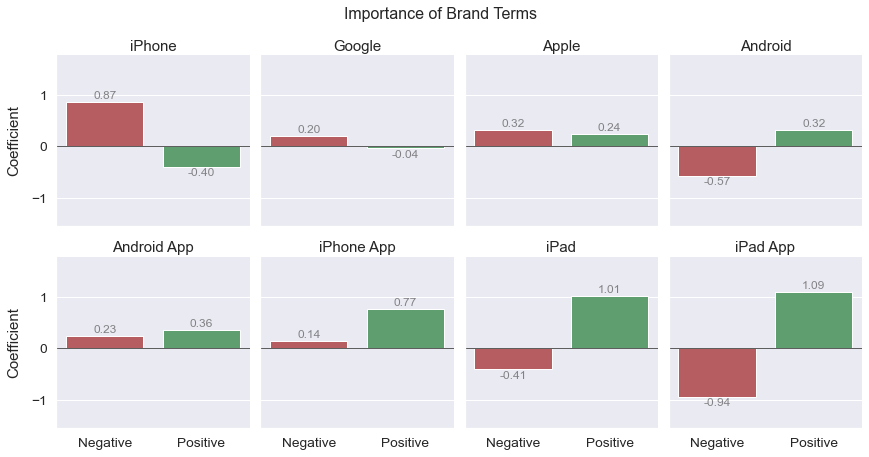

<IPython.core.display.Javascript object>

In [104]:
pos_neg_catplot(brand_coef, name="Brand Terms")

Interestingly, 'iPhone' has "negatively sloped" bars (if you imagine a line connecting them), whereas iPad has positively sloped bars. 'iPad App' is even more dramatically positive, and 'iPhone App' has a weak relationship with both 'Positive' and 'Negative'. 'iPhone App' does have a negative relationship with 'Neutral', however, indicating some amount of controversy.

'images\\apple_prod_term_coef.svg'

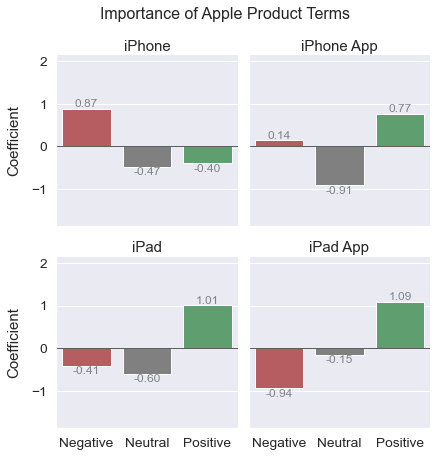

<IPython.core.display.Javascript object>

In [105]:
g = pos_neg_catplot(
    brand_coef.loc[["iPhone", "iPhone App", "iPad", "iPad App"]],
    name="Apple Product Terms",
    col_wrap=2,
    annot_pad=0.05,
    sup_y=1.05,
    drop_neutral=False,
)
plotting.save(g.fig, "images/apple_prod_term_coef.svg")

## VADER Valence
Here are the VADER coefficients. They are relatively large, as expected. Adding VADER vectors to the mix proved to be a good idea.

In [106]:
vad_coef = coef.filter(like="vad__", axis=0)
vad_coef.index = vad_coef.index.str.replace("vad__", "")
vad_coef = utils.title_mode(vad_coef)
vad_coef

,Negative,Neutral,Positive
Neg,2.522143,-1.109018,-1.413125
Neu,-0.684040,1.305543,-0.621503
Pos,-0.643010,-0.930538,1.573548


<IPython.core.display.Javascript object>

The 'Neg' VADER polarity scores have a strong relationship with 'Negative', unsurprisingly.

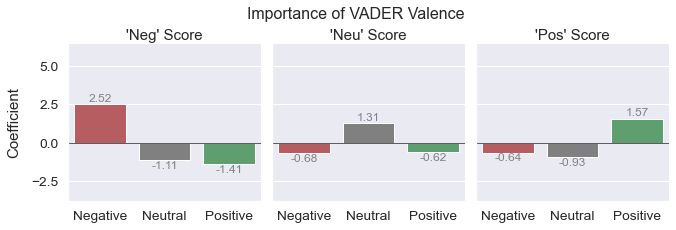

<IPython.core.display.Javascript object>

In [107]:
g = pos_neg_catplot(
    vad_coef,
    name="VADER Valence",
    col_wrap=3,
    annot_dist=0.45,
    annot_pad=0.1,
    drop_neutral=False,
)

g.set_titles("'{col_name}' Score")

# Recommendations

#### 1. Try to shake your authoritarian image by ostensibly allowing end-users more freedom.
People like that Apple products just work out of the box, but they find your paternalistic approach to managing your products off-putting. **Send the message** that when you buy an Apple product, you are free to do what you want with it. Keep control over the most important things, but relinquish control over the less important things. Make people feel like they have the freedom to customize your products as they see fit. Make some concessions to placate the majority, while allowing the elite techno-snobs to continue complaining on the fringe.

#### 2. Do something to improve the iPhone's battery life and turn it into a marketing campaign.
There were a lot complaints about the iPhone's battery life. One user suggested that their Blackberry was doing much better. There were also complaints about #batterykiller apps which use geolocation in the background. If you made a big publicized effort to increase the iPhone's battery life, that would get people excited.

#### 3. Expand the App Store offerings for iPad.
There is a lot of enthusiasm about iPad apps, and less about iPhone apps and iPhone in general. Focus more energy on both developing iPad apps and nurturing the iPad development community.

# Future Work
### Stacking Classifiers
After experimenting a little with Scikit-Learn's `StackingClassifier`, it's become clear that I could use it to develop a more accurate final model. The `StackingClassifier` trains several classifiers on the data and then trains a final classifier on the concatenated output of those classifiers. It also allows you to pass the training data to your final estimator, so the final estimator is trained both on prior data and the predictions of the classifier ensemble.

### Sophisticated Vectorization
I experimented some with Doc2Vec, a sophisticated unsupervised document vectorization algorithm, but didn't find it to offer any advantage over `FreqVectorizer` when trained on this small dataset. It proved to be slower, much more complicated, and much less interpretable. However, if trained on a large corpus of tweets, and then used to predict vectors for the present dataset, it could prove to be better than TF\*IDF vectorization. Even if the Doc2Vec vectors didn't turn out to be better than the TF\*IDF vectors, they could potentially augment them. A Doc2Vec model trained on a large corpus would probably contribute **novel information**.

# Conclusion

I created a reasonably accurate model, at around 0.68 accuracy and 0.67 balanced accuracy. However, I'm confident that I can raise increase the accuracy even more by stacking classifiers. I'd also like to try alternative methods of vectorization, but I'm not as confident that it will improve the model.

Through interpreting my model and conducting a brief exploratory analysis in [exploratory.ipynb](exploratory.ipynb), I arrived at three recommendations. First, you should relinquish a small (ceremonial) amount of control over your products in a public manner, to sent the message that you're not tyrants. Second, you should improve the iPhone's battery life and turn that into a rallying point for a marketing campaign. People are really concerned about their battery life. Third, you should invest money and resources into expanding iPad app development. People are excited about the iPad and its potential, and somewhat jaded about the iPhone.